# Python MCF tutorial
<i> Authors: Markus Viljanen </i>

In this tutorial we show how to estimate retention and monetization in censored data sets. We present five different scenarios where our method can be used: 

1. Simply calculating the number of sessions or purchases in a censored data set
2. Comparing the number of purchases in two cohorts based on platform (ios/android)
3. Using regression to compare 24 different cohorts based on platform/version/difficulty 
4. Extrapolating the number of purchases in a future version based on an old version 
5. Generalizing the method to real-valued costs such as Lifetime Value (LTV) instead of simply the number of purchases

<p><b> Table of contents </b></p>
<ul>
  <li><a href='#imports'>Imports</a></li>
  <li><a href='#motivation'>Motivation</a></li>
  <li><a href='#calculating'>Calculating the number of sessions or purchases</a></li>
  <li><a href='#comparison'>Comparison of number of purchases</a></li>
  <li><a href='#regression'>Regression of the number of purchases</a></li>
  <li><a href='#extrapolation'>Extrapolation of the number of purchases</a></li>
  <li><a href='#ltv'>Calculating the total playtime or the lifetime value</a></li>
</ul>

<a id='imports'></a>

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from data_operations import transform_data, mcf, mcfcost, mcfdiff, mcfequal,\
    plot_data, plot_datas, plot_mcf, plot_mcfs, plot_mcfdiff, plot_mcfdiffs

In [2]:
from scipy.stats import norm
confidence = 0.95
Z = norm.ppf((1.00 + confidence) / 2.0)

<a id='motivation'></a>

## Motivation

This small helper function is used to plot a single timeline of sessions or purchases:

In [3]:
def plot_timeline(events, title='Events', marker='o'):
    plt.figure(figsize=(5, 1))
    plt.text(0,1,'Player    ', horizontalalignment='right', verticalalignment='center')
    plt.scatter(events['Time'], events['Sample'], s=events['Cost']*40, marker=marker, color='black')
    for i, event in events.iterrows():
        plt.annotate(u"%.2f" % event['Cost'], (event['Time']+.02, event['Sample']+.02))
    plt.text(180,1,u'    Total %.2f' % events['Cost'].sum(), horizontalalignment='left', verticalalignment='center')
    plt.hlines(1, 0, 180, color='black', alpha=0.2)
    plt.title(title)
    plt.axis('off')

Monetization is measured by tracking the purchases of players. A player makes some purchases until they churn out of the game, and the total amount of money they brought in is their Lifetime Value (LTV). This is probably the single most important metric, because the profit is difference between their Lifetime Value and acquisiton cost. For example, in the below figure a player makes 4 purchases that total 7€, so if it costs 2€ to acquire the player through advertisements, we make 5€. 

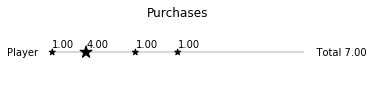

In [4]:
purchases = pd.DataFrame({'Sample': 1, 'Time': [1, 25, 60, 90], 'Cost': [1.0, 4.0, 1.0, 1.0]})
plot_timeline(purchases, title='Purchases', marker='*')

Retention is measured by tracking the activity of players. It is important to know that the players are enjoying the game, and several metrics measure how long the players play. This can also be an important proxy variable of how much potential there is to monetize if the monetization is based on advertisements or is not yet fully implemented. Perhaps the most complete measure is the total playtime per player. In the below figure, a player has 6 sessions with the total playtime of 3.05 hours




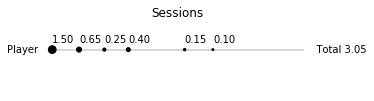

In [5]:
sessions = pd.DataFrame({'Sample': 1, 'Time': [1, 20, 38, 55, 95, 115,], 'Cost': [1.50, 0.65, 0.25, 0.40, 0.15, 0.10]})
plot_timeline(sessions, title='Sessions', marker='o')

The 'data.ipynb' notebook was used to generate the data sets. For more information about the data generation process, please see the notebook. Because the data sets were generated, we know the 'true' answers and can visualize both the estimates and the actual values. The sessions or purchases were generated with a session rate or a purchase rate $\lambda$ and a churn rate $\mu$. Each session has a duration or purchase has an amount, which is modelled as a random variable $C$ with the expectation $E[C]$.

The expected number of sessions or purchases at a given follow-up time $t$ is then given by:
$$E[N(t)] = \frac{\lambda}{\mu}(1 - \text{exp}(-\mu t))$$
The expected session duration or purchase amount is $E[C(t)] = E[C]E[N(t)]$


In [6]:
max_date, play_rate, purchase_rate, churn_rate, mean_playtime, mean_purchase = 180, 0.1, 0.004, 0.02, 0.25, 2.00
T = np.linspace(0, max_date, 100)
E_N = lambda T, rate, churn_rate : rate / churn_rate * (1 - np.exp(-churn_rate*T))
LTV = lambda T, rate, churn_rate, mean : mean * rate / churn_rate * (1 - np.exp(-churn_rate*T))

In [ ]:
<a id='calculating'></a>

## Calculating the number of sessions or purchases

First we are going to load two basic data sets for sessions and purchases:

In [7]:
data_sessions = pd.read_csv('tutorial/sessions.csv')
data_purchases = pd.read_csv('tutorial/purchases.csv')

The data sets consists of (Sample, Time, Event, Cost) rows:
* 'Sample' is the player id
* 'Time' is the event time
* 'Event' = 1 means the event was a session/purchase
* 'Event' = 0 means the event was the end of follow-up
* 'Cost' is the sesssion duration or purchase amount

In [8]:
data_sessions.head()

,Sample,Time,Event,Cost
0,1,136.177888,0,0.000000
1,2,16.412515,1,0.231831
2,2,107.428863,0,0.000000
3,3,0.062728,1,0.253390
4,3,2.101880,1,0.154260


In [9]:
data_purchases.head()

,Sample,Time,Event,Cost
0,1,136.177888,0,0.0
1,2,107.428863,0,0.0
2,3,89.585053,0,0.0
3,4,36.305943,0,0.0
4,5,22.274569,1,4.0


Lets plot the data first. We can use a simple plotting function after we transform the data into a 'counting process' format:

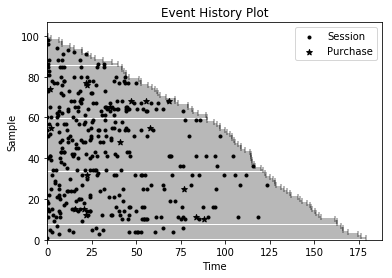

In [10]:
df_sessions = transform_data(data_sessions)
df_purchases = transform_data(data_purchases)

fig, ax = plt.subplots(1,1)
plot_data(df_sessions, ax=ax, marker='.', plot_costs=False, label='Session', alpha=0.2)
plot_data(df_purchases, ax=ax, marker='*', plot_costs=False, label='Purchase', alpha=0.2)

We would now like to estimate how many sessions or purchases the players do. However, we cannot simply take the average over players because the follow-up is limited and some players have been followed for longer than others. The Mean Cumulative Function (MCF) can be used to measure monetization and retention censored data sets. 

Lets calculate the expected number of sessions $E[N]$ as a function of follow-up time:

In [11]:
mcf_sessions = mcf(df_sessions, robust=True, positive=True)
mcf_sessions.head()

,Time,dN,dY,N,Y,dE[N],E[N],E[N].Var,E[N].ucl,E[N].lcl
0,0.000000,0,100,0,0.0,0.00,0.00,0.000000,0.000000,0.000000
1,0.002226,1,0,1,100.0,0.01,0.01,0.000099,0.070297,0.001423
2,0.062728,1,0,2,100.0,0.01,0.02,0.000196,0.078863,0.005072
3,0.139117,1,0,3,100.0,0.01,0.03,0.000291,0.091440,0.009843
4,0.158762,1,0,4,100.0,0.01,0.04,0.000384,0.104487,0.015313


We can use a simple plotting function to visualize the resuls:

(0, 8)

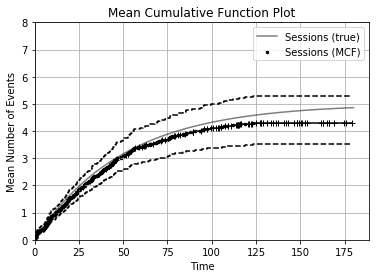

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(T, E_N(T, play_rate, churn_rate), linestyle='-', alpha=0.5, color='black', label='Sessions (true)')
plot_mcf(mcf_sessions, ax=ax, marker='.', label='Sessions (MCF)')
ax.set_ylim(0,8)

Lets calculate the expected number of purchases $E[N]$ as a function of follow-up time:

In [13]:
mcf_purchases = mcf(df_purchases, robust=True, positive=True)
mcf_purchases.head()

,Time,dN,dY,N,Y,dE[N],E[N],E[N].Var,E[N].ucl,E[N].lcl
0,0.000000,0,100,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.458748,0,-1,0,100.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.822383,1,0,1,99.0,0.010101,0.010101,0.000101,0.071000,0.001437
3,1.930503,0,-1,1,99.0,0.000000,0.010101,0.000101,0.071000,0.001437
4,2.272173,1,0,2,98.0,0.010204,0.020305,0.000202,0.080047,0.005151


(0.0, 0.4)

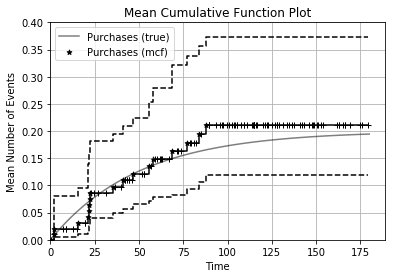

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(T, E_N(T, purchase_rate, churn_rate), linestyle='-', alpha=0.5, color='black', label='Purchases (true)')
plot_mcf(mcf_purchases, ax=ax, marker='*', label='Purchases (mcf)')
ax.set_ylim(0.00,0.40)

<a id='comparison'></a>

## Comparison of number of purchases

In the second example, we load a data set to compare players:

In [15]:
data_purchases = pd.read_csv('tutorial/purchases_compare.csv')
data_purchases.head()

,Sample,Time,Time_prev,Event,Cost,Platform
0,1,120.799234,0.0,0,0.0,ios
1,2,175.807277,0.0,0,0.0,ios
2,3,135.025952,0.0,0,0.0,ios
3,4,166.043003,0.0,0,0.0,ios
4,5,25.205394,0.0,0,0.0,ios


This data set has an extra 'Platform' column. It looks like there are 'android' and 'ios' platforms with 100 players each:

In [16]:
data_purchases.groupby('Platform')['Sample'].agg(lambda s: len(s.unique()))

Platform
android    100
ios        100
Name: Sample, dtype: int64

Lets first plot the data to understand it better. It looks like 'ios' might have more purchases than 'android':

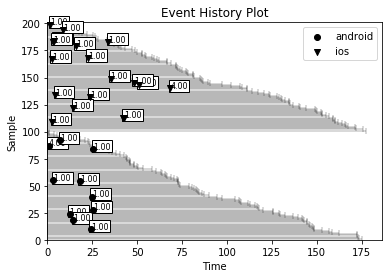

In [17]:
df_purchases = transform_data(data_purchases)
df_android = df_purchases[df_purchases['Platform'] == 'android']
df_ios = df_purchases[df_purchases['Platform'] == 'ios']

fig, ax = plt.subplots(1,1)
plot_datas([('android', df_android), ('ios', df_ios)], ax=ax, alpha=0.2)

We can plot the MCF of both 'android' and 'ios' to compare them. It looks like there will be 0.25 purchases in ios and 0.08 purchases in android:

(0.0, 0.4)

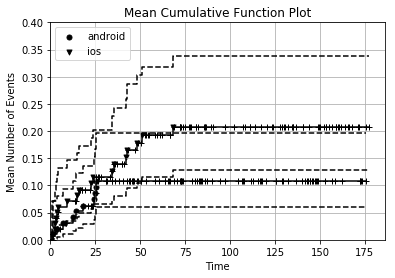

In [18]:
mcf_android = mcf(df_android, robust=True, positive=True)
mcf_ios = mcf(df_ios, robust=True, positive=True)

fig, ax = plt.subplots(1,1)
plot_mcfs([('android', mcf_android), ('ios', mcf_ios)], ax=ax)
ax.set_ylim(0.00,0.40)

A simple function mcfdiff can be used to compare the two mcf curves. It looks like ios has 0.17 more purchases than android:

(0.0, 0.4)

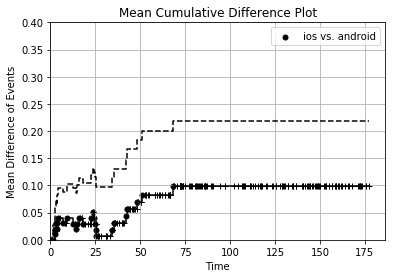

In [19]:
mcf_diff = mcfdiff(mcf_ios, mcf_android)

fig, ax = plt.subplots(1,1)
plot_mcfdiff(mcf_diff, ax=ax, label='%s vs. %s' % ('ios', 'android'))
ax.set_ylim(0.00,0.40)

The comparison indicates that the difference is statistically significant, because the confidence intervals do not contain zero. However, this comparison is pointwise, meaning that it measures the difference at a given time point. A simple function mcfequal can be used to test the null hypothesis that the mcf curves are equal. We obtain a p-value that provides strong evidence against this hypothesis:

In [20]:
p_value = mcfequal(df_ios, df_android, robust=True)
print "p-value: %.3f" % (p_value)

p-value: 0.142


<a id='regression'></a>

## Regression of the number of purchases

In the third example, we load a data set to compare players with many different features:

In [21]:
data_purchases = pd.read_csv('tutorial/purchases_regression.csv')
data_purchases.head()

,Sample,Time,Time_prev,Event,Cost,Platform,Country,Difficulty
0,1,22.892279,0.0,0,0.0,android,GB,easy
1,2,16.528882,0.0,0,0.0,android,GB,easy
2,3,130.662169,0.0,0,0.0,android,GB,easy
3,4,108.497087,0.0,0,0.0,android,GB,easy
4,5,117.504999,0.0,0,0.0,android,GB,easy


There are now three extra columns 'Platform', 'Country', and 'Difficulty'. These define 24 different cohorts with 50 players each:

In [22]:
covariates = ['Platform', 'Country', 'Difficulty']
to_string = lambda elements : ' / '.join(elements)

data_purchases.groupby(covariates)['Sample'].agg(lambda s: len(s.unique()))

Platform  Country  Difficulty
android   AU       easy          50
                   hard          50
                   normal        50
          GB       easy          50
                   hard          50
                   normal        50
          NL       easy          50
                   hard          50
                   normal        50
          US       easy          50
                   hard          50
                   normal        50
ios       AU       easy          50
                   hard          50
                   normal        50
          GB       easy          50
                   hard          50
                   normal        50
          NL       easy          50
                   hard          50
                   normal        50
          US       easy          50
                   hard          50
                   normal        50
Name: Sample, dtype: int64

We plot the data, but see that it is quite difficult to make sense of this many cohorts:

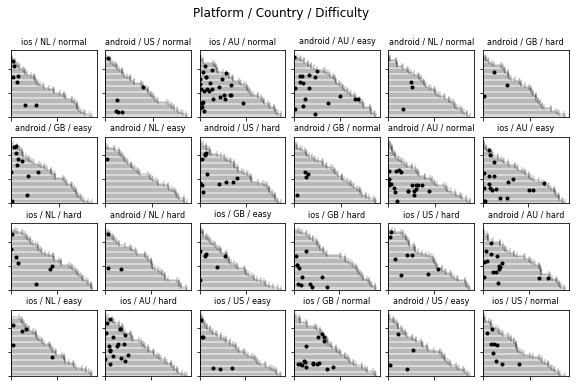

In [23]:
df_purchases = transform_data(data_purchases)
df_cohorts = {to_string(cohort): df for cohort, df in df_purchases.groupby(covariates)}

fig = plt.figure(figsize=(10, 6))
fig.suptitle(to_string(covariates))
gs = gridspec.GridSpec(4, 6)
gs.update(wspace=0.1, hspace=0.3)
for i, cohort in enumerate(df_cohorts):
    ax = fig.add_subplot(gs[i])
    plot_data(df_cohorts[cohort], ax, marker='.', alpha=0.2, plot_costs=False)
    ax.set_title(cohort, fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])


The combination of platform/country/difficulty defines simply too many MCFs to have a clear comparisons:

(0.0, 0.8)

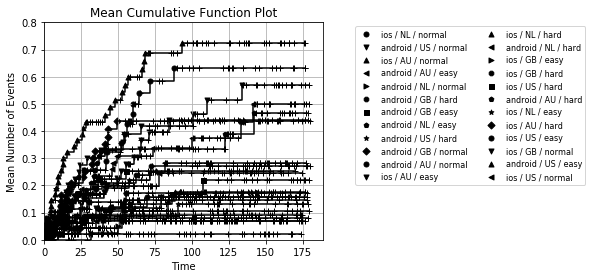

In [24]:
mcfs = {to_string(cohort): mcf(df, robust=True, positive=False) for cohort, df in df_purchases.groupby(covariates)}

fig, ax = plt.subplots(1,1, figsize=(5, 4))
plot_mcfs(mcfs.items(), ax=ax, CI=False)
ax.legend(fontsize=8, bbox_to_anchor=(1.1, 1.0), ncol=2)
ax.set_ylim([0.00, 0.80])

One solution is to use regression. However, the Python MCF package does not (yet) implement regression. We therefore used R in the 'tutorial_regression.ipynb' notebook to analyze the effect of platform/country/version and predict the MCF curve for each cohort.

> Open the 'tutorial_regression.ipynb' notebook to see the R regression results

First, load the predicted 'MCF curves' for different cohorts:

In [25]:
predict = pd.read_csv('tutorial/purchases_regression_predict.csv')
predict.head()

,Time,N,N.var,Platform,Country,Difficulty
0,0.006839,0.000000,0.000000e+00,android,GB,normal
1,0.009385,0.000701,7.936225e-09,android,GB,normal
2,0.074281,0.001401,3.174490e-08,android,GB,normal
3,0.165879,0.002102,7.142602e-08,android,GB,normal
4,0.195003,0.002102,7.142602e-08,android,GB,normal


The population MCF curve looks like this:

(0.0, 0.6)

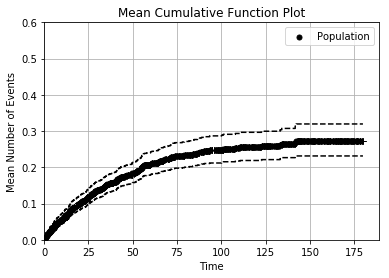

In [26]:
df_purchases = transform_data(data_purchases)
mcf_purchases = mcf(df_purchases, robust=True, positive=True)

fig, ax  = plt.subplots(1, 1)
plot_mcf(mcf_purchases, ax=ax, cost=False, label='Population')
ax.set_ylim(0.00, 0.60)

The following widget can be used to test how the predictions given by R would look like in different cohorts:

In [27]:
def f(platform, country, version):
    cohort = 'Cohort: ' + ', '.join([platform, country, version])
    reg = predict[(predict['Platform'] == platform) & (predict['Country'] == country) & (predict['Difficulty'] == version)]
    reg = reg.copy()
    with np.errstate(divide='ignore'):
        reg['N.ucl'] = np.exp(np.log(reg['N']) + Z*np.sqrt(reg['N.var'])/reg['N'])#reg['N'] + Z*np.sqrt(reg['N.var'])
        reg['N.lcl'] = np.exp(np.log(reg['N']) - Z*np.sqrt(reg['N.var'])/reg['N'])#reg['N'] - Z*np.sqrt(reg['N.var'])
    
    fig, ax  = plt.subplots(1, 1)
    ax.plot(reg['Time'], reg['N'], marker='', linestyle='-', drawstyle='steps-post', color='black', label=cohort)
    ax.plot(reg['Time'], reg['N.ucl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    ax.plot(reg['Time'], reg['N.lcl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    #ax.set_ylim(0.00, 0.60)
    ax.set_title('Cox Model Prediction')
    ax.set_ylabel('Mean Number of Events')
    ax.set_xlabel('Time')
    ax.legend()
    ax.grid()

_ = widgets.interact(f, platform=['android', 'ios'], country=['GB', 'US', 'NL', 'AU'], version=['easy', 'normal', 'hard'])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGxhdGZvcm0nLCBvcHRpb25zPSgnYW5kcm9pZCcsICdpb3MnKSwgdmFsdWU9J2FuZHJvaWQnKSwgRHJvcGRvd27igKY=


<a id='extrapolation'></a>

## Extrapolation of the number of purchases

In the fourth example, we load a data set to compare game versions:

In [28]:
data_purchases = pd.read_csv('tutorial/purchases_extrapolate.csv')
data_purchases.head()

,Sample,Time,Time_prev,Event,Cost,Version
0,1,63.647824,0.0,0,0.0,old
1,2,125.229518,0.0,0,0.0,old
2,3,173.641979,0.0,0,0.0,old
3,4,35.900407,0.0,0,0.0,old
4,5,154.580784,0.0,0,0.0,old


There is one extra column 'Version', which differs by the number of players and maximum follow-up:

In [29]:
print(data_purchases.groupby('Version')['Sample'].agg(lambda s: len(s.unique())))
print(data_purchases.groupby('Version')['Time'].agg('max'))

Version
new    100
old    300
Name: Sample, dtype: int64
Version
new     59.097638
old    179.522680
Name: Time, dtype: float64


Lets visualize the data to understand it better. We see that the new version is more recent so there is less data:

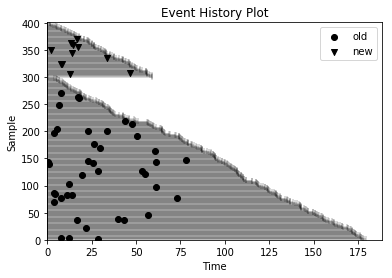

In [30]:
df_purchases = transform_data(data_purchases)
df_old = df_purchases[df_purchases['Version'] == 'old']
df_new = df_purchases[df_purchases['Version'] == 'new']

fig, ax  = plt.subplots(1, 1)
plot_datas([('old', df_old), ('new', df_new)], ax=ax, plot_costs=False, alpha=0.2)

Based on the MCF comparison, it would be desirable to extrapolate what happens in the 'new' version based on what we know of the 'old' version:

(0.0, 0.4)

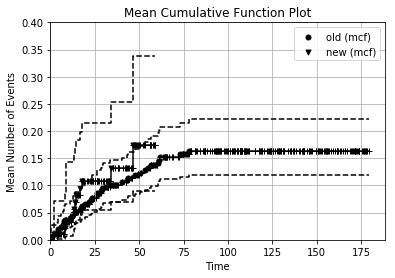

In [31]:
mcf_old = mcf(df_old, robust=True, positive=True)
mcf_new = mcf(df_new, robust=True, positive=True)

fig, ax  = plt.subplots(1, 1)
plot_mcfs([('old (mcf)', mcf_old), ('new (mcf)', mcf_new)], ax=ax, CI=True)
ax.set_ylim(0.00, 0.40)

This can be done with regression, by finding the cofficient of how the new version is proportional to the old. 

Lets load the predictions from our R analysis:

In [32]:
extrapolate = pd.read_csv('tutorial/purchases_extrapolate_predict.csv', sep=',')
extrapolate.head()

,Time,N,N.var,Version
0,0.246977,0.000000,0.000000e+00,old
1,0.339185,0.002333,4.111318e-08,old
2,0.906544,0.004666,1.644527e-07,old
3,1.327629,0.004666,1.644527e-07,old
4,1.807470,0.004666,1.644527e-07,old


The following widget can be used to test how the predictions would look like for the 'new' and 'old' version:

In [33]:
def f(version):
    reg = extrapolate[extrapolate['Version'] == version]
    reg = reg.copy()
    with np.errstate(divide='ignore'):
        reg['N.ucl'] = np.exp(np.log(reg['N']) + Z*np.sqrt(reg['N.var'])/reg['N'])#reg['N'] + Z*np.sqrt(reg['N.var'])
        reg['N.lcl'] = np.exp(np.log(reg['N']) - Z*np.sqrt(reg['N.var'])/reg['N'])#reg['N'] - Z*np.sqrt(reg['N.var'])
        
    fig, ax  = plt.subplots(1, 1)
    plot_mcfs([('old (mcf)', mcf_old), ('new (mcf)', mcf_new)], ax=ax, CI=False)
    ax.plot(reg['Time'], reg['N'], marker='', linestyle='-', drawstyle='steps-post', color='black', label='%s (cox)' % version)
    ax.plot(reg['Time'], reg['N.ucl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    ax.plot(reg['Time'], reg['N.lcl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    ax.legend()
    ax.set_title('Cox Model Prediction')
    ax.set_ylim(0.00, 0.40)

_ = widgets.interact(f, version=['old', 'new'])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUndmVyc2lvbicsIG9wdGlvbnM9KCdvbGQnLCAnbmV3JyksIHZhbHVlPSdvbGQnKSwgT3V0cHV0KCkpLCBfZG9tX2PigKY=


<a id='ltv'></a>

## Calculating the total playtime or the lifetime value

The previous analysis were focused on the number of sessions or purchases. However, it would be desirable to calculate the total playtime or the lifetime value, which also depend on the session durations or the purchase amounts. In fact, the MCF directly generalizes to real-value data.

First, lets load the same data sets as in the first example:

In [34]:
data_sessions = pd.read_csv('tutorial/sessions.csv')
data_purchases = pd.read_csv('tutorial/purchases.csv')

If we take into account the session durations the data looks like this:

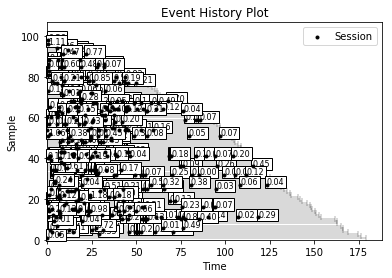

In [35]:
df_sessions = transform_data(data_sessions)

fig, ax = plt.subplots(1, 1)
plot_data(df_sessions, ax=ax, marker='.', label='Session', alpha=0.2)

Lets calculate the expected playtime $E[C]$ (or 'Cost') as a function of follow-up time:

In [36]:
mcf_playtime = mcfcost(df_sessions, robust=True, positive=True)
mcf_playtime.head()

,Time,dC,dN,dY,Y,dE[C],E[C],E[C].Var,E[C].ucl,E[C].lcl
0,0.000000,0.000000,0,100,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,0.002226,0.045287,1,0,100.0,0.000453,0.000453,2.030426e-07,0.003184,0.000064
2,0.062728,0.253390,1,0,100.0,0.002534,0.002987,6.536551e-06,0.015989,0.000558
3,0.139117,0.149212,1,0,100.0,0.001492,0.004479,8.651572e-06,0.016224,0.001236
4,0.158762,0.130073,1,0,100.0,0.001301,0.005780,1.021003e-05,0.017080,0.001956


The same function can be used to plot the results:

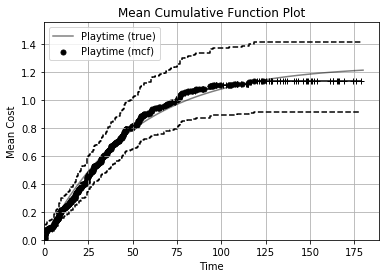

In [37]:
fig, ax = plt.subplots(1, 1)
ax.plot(T, LTV(T, play_rate, churn_rate, mean_playtime) , linestyle='-', alpha=0.5, color='black', label='Playtime (true)')
plot_mcf(mcf_playtime, ax=ax, cost=True, label='Playtime (mcf)')

If we take into account the purchase amounts the data looks like this:

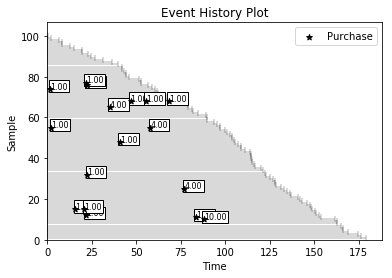

In [38]:
df_purchases = transform_data(data_purchases)

fig, ax = plt.subplots(1, 1)
plot_data(df_purchases, ax=ax, marker='*', label='Purchase', alpha=0.2)

Lets calculate the expected lifetime value $E[C]$ (or 'Cost') as a function of follow-up time:

In [39]:
df_purchases = transform_data(data_purchases)
mcf_ltv = mcfcost(df_purchases, robust=True, positive=True)
mcf_ltv.head()

,Time,dC,dN,dY,Y,dE[C],E[C],E[C].Var,E[C].ucl,E[C].lcl
0,0.000000,0.0,0,100,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.458748,0.0,0,-1,100.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.822383,1.0,1,0,99.0,0.010101,0.010101,0.000101,0.071000,0.001437
3,1.930503,0.0,0,-1,99.0,0.000000,0.010101,0.000101,0.071000,0.001437
4,2.272173,1.0,1,0,98.0,0.010204,0.020305,0.000202,0.080047,0.005151


The same function can be used to plot the results:

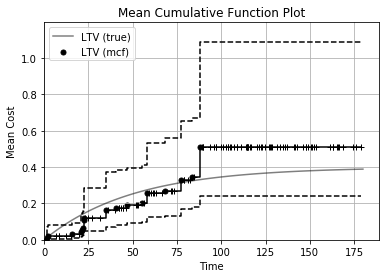

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(T, LTV(T, purchase_rate, churn_rate, mean_purchase) , linestyle='-', alpha=0.5, color='black', label='LTV (true)')
plot_mcf(mcf_ltv, ax=ax, cost=True, label='LTV (mcf)')

Finally, it is possible to incorporate total costs into the regression framework. However, the R 'survival' package does not directly support regression with events that have a real valued 'cost'. We therefore assume that the event process and the costs are independent and fit two separate models:
1. Regression on the number of purchases (Cox proportional hazards)
2. Regression on the purchase amount (Standard least squares)

First we load the predictions:

In [41]:
predict = pd.read_csv('tutorial/purchases_regression_predict.csv')
predict.head()

,Time,N,N.var,Platform,Country,Difficulty
0,0.006839,0.000000,0.000000e+00,android,GB,normal
1,0.009385,0.000701,7.936225e-09,android,GB,normal
2,0.074281,0.001401,3.174490e-08,android,GB,normal
3,0.165879,0.002102,7.142602e-08,android,GB,normal
4,0.195003,0.002102,7.142602e-08,android,GB,normal


In [42]:
amount = pd.read_csv('tutorial/purchases_regression_amount.csv', sep=',')
amount.head()

,E,E.var,Platform,Country,Difficulty
0,2.093834,0.238009,android,GB,normal
1,1.882122,0.238417,android,GB,easy
2,1.922546,0.250496,android,GB,hard
3,2.111275,0.143256,android,AU,normal
4,1.899564,0.151918,android,AU,easy


The MCF for the entire population of players looks like this:

(0.0, 1.0)

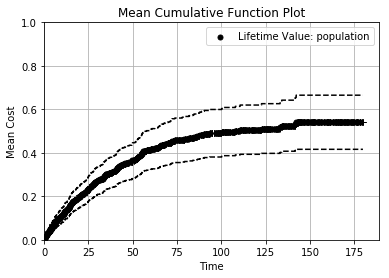

In [43]:
data_purchases = pd.read_csv('tutorial/purchases_regression.csv')
df_purchases = transform_data(data_purchases)
mcf_purchases = mcf(df_purchases, robust=True, positive=False)
mcf_ltv = mcfcost(df_purchases, mcf_compound=mcf_purchases, positive=False)

fig, ax  = plt.subplots(1, 1)
plot_mcf(mcf_ltv, ax=ax, cost=True, label='Lifetime Value: population')
ax.set_ylim(0.00, 1.00)

The following widget can be used to visualize the regression predictions:

In [44]:
def f(platform, country, version):
    lsq = amount[(amount['Platform'] == platform) & (amount['Country'] == country) & (amount['Difficulty'] == version)].iloc[0,]
    reg = predict[(predict['Platform'] == platform) & (predict['Country'] == country) & (predict['Difficulty'] == version)]
    reg = reg.copy()
    reg['C'] = lsq['E']*reg['N']
    reg['C.var'] = lsq['E']**2 * reg['N.var'] + lsq['E.var'] * reg['N']**2
    with np.errstate(divide='ignore'):
        reg['C.ucl'] = np.exp(np.log(reg['C']) + Z*np.sqrt(reg['C.var'])/reg['C'])#reg['C'] + Z*np.sqrt(reg['C.var'])
        reg['C.lcl'] = np.exp(np.log(reg['C']) - Z*np.sqrt(reg['C.var'])/reg['C'])#reg['C'] - Z*np.sqrt(reg['C.var'])

    fig, ax = plt.subplots(1, 1)
    cohort = 'Lifetime Value: ' + ', '.join([platform, country, version])
    ax.plot(reg['Time'], reg['C'], marker='', linestyle='-', drawstyle='steps-post', color='black', label=cohort)
    ax.plot(reg['Time'], reg['C.ucl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    ax.plot(reg['Time'], reg['C.lcl'], marker='', linestyle='--', drawstyle='steps-post', color='black', label='')
    #ax.set_ylim(0.00, 1.00)
    ax.set_title('Cox Model Prediction')
    ax.set_ylabel('Mean Cost')
    ax.set_xlabel('Time')
    ax.legend()
    ax.grid()

_ = widgets.interact(f, platform=['android', 'ios'], country=['GB', 'US', 'NL', 'AU'], version=['easy', 'normal', 'hard'])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncGxhdGZvcm0nLCBvcHRpb25zPSgnYW5kcm9pZCcsICdpb3MnKSwgdmFsdWU9J2FuZHJvaWQnKSwgRHJvcGRvd27igKY=
